## Setup of the extractor


In [ ]:
import random
import pymupdf
import random
from collections import Counter
import pandas as pd


# Some ideas taken from mineru
class PDFFeatureExtractor():
    """
    PDF Feature Extractor for OCR Classification
    
    This class extracts comprehensive features from PDF documents to help classify
    whether they require OCR processing or contain native text. The extractor
    analyzes multiple aspects of PDF structure and content:
    
    Document-level features:
    - Form detection (interactive PDF forms)
    - Scanner detection via metadata (creator/producer fields)
    - Garbled text ratio (replacement characters indicating OCR artifacts)
    
    Text-based features (per page):
    - Font diversity (unique font counts)
    - Character and text box counts
    - Text area coverage ratios
    - Hidden text detection (invisible or transparent text layers)
    - Average text box dimensions
    
    Image-based features (per page):
    - Image instance counts (total and non-junk)
    - Bitmap area coverage and proportions
    - Image strip merging for scanned document detection
    - Junk image filtering (repeated decorative elements)
    
    Vector graphics features (per page):
    - Drawing stroke counts
    - Vector graphics object counts
    
    The extractor uses sampling strategies to efficiently process large documents
    while maintaining statistical representativeness. It can detect scanned
    documents, image-heavy PDFs, and native text documents with high accuracy.
    """
    JUNK_IMAGE_THRESHOLD_RATIO = 0.5
    JUNK_IMAGE_MIN_PAGES_FOR_THRESHOLD = 3
    MERGE_MAX_OFFSET = 5
    MERGE_MAX_GAP = 2
    # Define known scanner strings for creator/producer check
    KNOWN_SCANNER_STRINGS = [
        "scanner", "scan", "epson", "hp scanjet", "canon", "fujitsu",
        "kodak", "brother", "xerox", "lexmark", "kmc", "kofax", "ricoh",
        "iris", "capturedocument", "paperport", "readiris", "simpleocr"
    ]


    def __init__(self, num_pages_to_sample: int = 5, num_chunks: int = 1):
        if not isinstance(num_pages_to_sample, int):
            raise ValueError("num_pages_to_sample must be an integer.")
        self.num_pages_to_sample = num_pages_to_sample
        self.num_chunks = num_chunks

    def get_garbled_text_per_age(self, doc: pymupdf.Document):
        all_text = []
        garbled_text = []
        for page in doc:
            page_text = page.get_text("text", flags=pymupdf.TEXT_PRESERVE_WHITESPACE | pymupdf.TEXT_MEDIABOX_CLIP)
            all_text.append(len(page_text))
            garbled_text.append(page_text.count(chr(0xfffd)))

        return all_text, garbled_text

    def _get_sampled_page_indices(self, doc: pymupdf.Document) -> list[list[int]]:
        total_pages = len(doc)
        if total_pages == 0: return []

        # If num_pages_to_sample is non-positive, return empty list
        if self.num_pages_to_sample <= 0:
            return []

        # Sample indices without replacement
        available_indices = list(range(total_pages))
        sampled_indices = []
        
        # Sample up to num_chunks, each with num_pages_to_sample indices
        if self.num_chunks == -1:
            num_chunks = len(available_indices) // self.num_pages_to_sample + 1
        else:
            num_chunks = self.num_chunks

        for _ in range(num_chunks):
            # Break if not enough pages left for another chunk
            if len(available_indices) == 0:
                break
                
            # Sample min of available pages and pages_per_chunk
            chunk_size = min(self.num_pages_to_sample, len(available_indices))
            chunk = random.sample(available_indices, chunk_size)
            
            # Remove sampled indices from available pool
            for idx in chunk:
                available_indices.remove(idx)
                
            sampled_indices.append(sorted(chunk))
            
        return sampled_indices

    def _heuristic_merge_image_strips_on_page(self, single_page_image_list: list, page_width: float, page_height: float) -> list:
        if not single_page_image_list:
            return []

        page_images_deduped_by_bbox = []
        dedup_bboxes = set()
        for img_data in single_page_image_list:
            bbox_tuple = (img_data[0], img_data[1], img_data[2], img_data[3])
            if bbox_tuple not in dedup_bboxes:
                dedup_bboxes.add(bbox_tuple)
                page_images_deduped_by_bbox.append(img_data)

        if not page_images_deduped_by_bbox:
            return []

        page_images_deduped_by_bbox.sort(key=lambda img: (img[1], img[0]))

        if not page_images_deduped_by_bbox:
            return []
        current_page_merged_list = [page_images_deduped_by_bbox[0]]

        for img_to_potentially_merge in page_images_deduped_by_bbox[1:]:
            x0_curr, y0_curr, x1_curr, y1_curr, imgid_curr = img_to_potentially_merge
            last_merged_img = current_page_merged_list[-1]
            x0_last, y0_last, x1_last, y1_last, _ = last_merged_img

            img_curr_width = abs(x1_curr - x0_curr)
            img_curr_height = abs(y1_curr - y0_curr)

            full_width_curr = page_width > 0 and (img_curr_width >= page_width * 0.9)
            full_height_curr = page_height > 0 and (img_curr_height >= page_height * 0.9)

            can_merge = False
            if full_width_curr:
                is_vertically_aligned_and_close = \
                    (abs(x0_last - x0_curr) <= self.MERGE_MAX_OFFSET) and \
                    (abs(x1_last - x1_curr) <= self.MERGE_MAX_OFFSET) and \
                    (abs(y0_curr - y1_last) <= self.MERGE_MAX_GAP)
                if is_vertically_aligned_and_close:
                    can_merge = True

            if not can_merge and full_height_curr:
                is_horizontally_aligned_and_close = \
                    (abs(y0_last - y0_curr) <= self.MERGE_MAX_OFFSET) and \
                    (abs(y1_last - y1_curr) <= self.MERGE_MAX_OFFSET) and \
                    (abs(x0_curr - x1_last) <= self.MERGE_MAX_GAP)
                if is_horizontally_aligned_and_close:
                    can_merge = True

            if can_merge:
                current_page_merged_list[-1] = [
                    min(x0_curr, x0_last), min(y0_curr, y0_last),
                    max(x1_curr, x1_last), max(y1_curr, y1_last),
                    imgid_curr
                ]
            else:
                current_page_merged_list.append(img_to_potentially_merge)

        return current_page_merged_list

    def _extract_document_level_stats_from_sampled_pages(self, doc: pymupdf.Document, sampled_page_indices: list[int]) -> dict:
        # This function will calculate doc-level stats based ONLY on the sampled pages.
        doc_stats = {
            # "num_unique_image_xrefs": 0,
            # "num_junk_image_xrefs": 0,
            "junk_image_xrefs_list": [] # This will be calculated and returned for use in page-level stats
        }

        if not sampled_page_indices: # No pages sampled or document is empty
            return doc_stats | {"junk_image_xrefs_list": []}


        img_xrefs_all_instances_sampled = [] # Stores xref for each instance across sampled pages
        page_unique_xrefs_map_sampled = {}   # Stores set of unique xrefs per sampled_page_idx

        for page_idx in sampled_page_indices:
            try:
                page = doc.load_page(page_idx)
                current_page_unique_xrefs = set()
                image_definitions_on_page = page.get_images(full=False)

                for img_def_tuple in image_definitions_on_page:
                    xref = img_def_tuple[0]
                    if xref == 0: continue
                    current_page_unique_xrefs.add(xref)
                    img_xrefs_all_instances_sampled.append(xref)
                page_unique_xrefs_map_sampled[page_idx] = current_page_unique_xrefs
            except Exception as e:
                print(f"Error processing page {page_idx}")
                # print(f"Warning: Could not get image info for page {page_idx} in doc stats: {e}")
                page_unique_xrefs_map_sampled[page_idx] = set()

        if not img_xrefs_all_instances_sampled:
            return doc_stats | {"junk_image_xrefs_list": []}

        uniq_img_xrefs_doc_wide_sampled = set(img_xrefs_all_instances_sampled)
        doc_stats["num_unique_image_xrefs"] = len(uniq_img_xrefs_doc_wide_sampled)

        xref_counts_across_sampled_pages = Counter()
        for page_xrefs_set in page_unique_xrefs_map_sampled.values():
            xref_counts_across_sampled_pages.update(page_xrefs_set)
        
        num_sampled_pages_for_junk_calc = len(sampled_page_indices)
        min_page_occurrence_threshold = max(
            num_sampled_pages_for_junk_calc * self.JUNK_IMAGE_THRESHOLD_RATIO,
            float(self.JUNK_IMAGE_MIN_PAGES_FOR_THRESHOLD)
        )
        # Ensure threshold is not greater than the number of sampled pages
        min_page_occurrence_threshold = num_sampled_pages_for_junk_calc


        current_junk_xrefs_list = []
        for xref, count_on_pages in xref_counts_across_sampled_pages.items():
            if count_on_pages >= min_page_occurrence_threshold and num_sampled_pages_for_junk_calc >= self.JUNK_IMAGE_MIN_PAGES_FOR_THRESHOLD :
                current_junk_xrefs_list.append(xref)
        
        # If only one page sampled, no image can be junk by this definition
        if num_sampled_pages_for_junk_calc < self.JUNK_IMAGE_MIN_PAGES_FOR_THRESHOLD:
             current_junk_xrefs_list = []


        doc_stats["num_junk_image_xrefs"] = len(current_junk_xrefs_list)

        return doc_stats | {"junk_image_xrefs_list": current_junk_xrefs_list}

    def _check_creator_producer_scanner(self, doc: pymupdf.Document) -> bool:
        metadata = doc.metadata
        creator = metadata.get("creator", "").lower()
        producer = metadata.get("producer", "").lower()
        for scanner_keyword in self.KNOWN_SCANNER_STRINGS:
            if scanner_keyword in creator or scanner_keyword in producer:
                return True
        return False

    def extract_all_features(self, doc: pymupdf.Document) -> list[dict]:
        sampled_page_indices_to_try = self._get_sampled_page_indices(doc)

        return [self.compute_features_per_chunk(doc, indices) for indices in sampled_page_indices_to_try]

    def compute_features_per_chunk(self, doc: pymupdf.Document, sampled_page_indices_to_try: list[int]) -> dict:
        features = {
            "is_form": False,
            "creator_or_producer_is_known_scanner": False,
            "garbled_text_ratio": 0,
            # Page level stats
            "page_level_unique_font_counts": [],
            "page_level_char_counts": [],
            "page_level_text_box_counts": [],
            "page_level_avg_text_box_lengths": [],
            "page_level_text_area_ratios": [],
            "page_level_hidden_char_counts": [],
            "page_level_hidden_text_box_counts": [],
            "page_level_hidden_avg_text_box_lengths": [],
            "page_level_hidden_text_area_ratios": [],
            "page_level_image_counts": [],
            "page_level_non_junk_image_counts": [],
            "page_level_bitmap_proportions": [],
            "page_level_max_merged_strip_areas": [],
            "page_level_drawing_strokes_count": [],
            "page_level_vector_graphics_obj_count": [],
            "num_pages_successfully_sampled": 0,
            "num_pages_requested_for_sampling": 0,
            "sampled_page_indices": []
        }

        
        features["num_pages_requested_for_sampling"] = len(sampled_page_indices_to_try)
        if not sampled_page_indices_to_try: # No pages to sample
             return features


        # 2. Extract document-level stats based *only* on these sampled pages
        doc_level_stats_and_junk_list = self._extract_document_level_stats_from_sampled_pages(doc, sampled_page_indices_to_try)
        # features["num_unique_image_xrefs"] = doc_level_stats_and_junk_list["num_unique_image_xrefs"]
        # features["num_junk_image_xrefs"] = doc_level_stats_and_junk_list["num_junk_image_xrefs"]
        
        junk_image_xrefs_from_sampled = set(doc_level_stats_and_junk_list.get("junk_image_xrefs_list", []))

        # 3. Document-level miscellaneous features
        features["is_form"] = bool(doc.is_form_pdf) if doc.is_form_pdf is not None else False # doc.is_form can be None
        features["creator_or_producer_is_known_scanner"] = self._check_creator_producer_scanner(doc)

        # --- Garbled text ratio ---
        all_text, garbled_text = self.get_garbled_text_per_age(doc)
        all_text_sum = sum(all_text)
        garbled_text_sum = sum(garbled_text)
        if all_text_sum == 0:
            features["global_garbled_text_ratio"] = 0
        else:
            features["global_garbled_text_ratio"] = garbled_text_sum / all_text_sum

        sampled_garbled_text = sum([garbled_text[i] for i in sampled_page_indices_to_try])
        sampled_all_text_sum = sum([all_text[i] for i in sampled_page_indices_to_try])
        if sampled_all_text_sum == 0:
            features["garbled_text_ratio"] = 0
        else:
            features["garbled_text_ratio"] = sampled_garbled_text / sampled_all_text_sum


        # 4. Page-level stats for sampled pages
        for page_idx in sampled_page_indices_to_try:
            try:
                page = doc.load_page(page_idx)
            except Exception:
                print(f"Error processing page {page_idx}")
                # If page load fails, we don't increment successfully_sampled count
                # and don't append to page_level lists for this page.
                # This means lists might be shorter than num_pages_requested_for_sampling.
                # Alternatively, append default/None values if strict list length is needed.
                continue

            features["sampled_page_indices"].append(page_idx)
            features["num_pages_successfully_sampled"] += 1

            page_rect_obj = page.rect
            page_area_pts = float(page_rect_obj.width * page_rect_obj.height)
            if page_area_pts == 0: page_area_pts = 1.0 # Avoid division by zero

            # --- Text features ---
            current_page_fonts = set()
            try:
                for fi in page.get_fonts(full=True):
                    if len(fi) > 3 and fi[3]: # Font name
                        current_page_fonts.add(fi[3])
            except Exception:
                print(f"Error processing page {page_idx}")
                pass

            features["page_level_unique_font_counts"].append(len(current_page_fonts))

            page_char_count    = 0
            page_text_total_area = 0
            page_text_box_count = 0
            page_hidden_total_area  = 0
            page_hidden_char_count     = 0
            page_hidden_box_count = 0

            for tr in page.get_texttrace():   
                n = len([c[0] for c in tr.get("chars", [])])

                # --- hidden‑text tests ---------------------------------------------------
                if tr.get("type") == 3 or tr.get("opacity", 1.0) == 0:
                    page_hidden_char_count += n
                    page_hidden_total_area += (tr.get("bbox")[2] - tr.get("bbox")[0]) * (tr.get("bbox")[3] - tr.get("bbox")[1])
                    page_hidden_box_count += 1
                else:
                    page_char_count += n
                    page_text_total_area += (tr.get("bbox")[2] - tr.get("bbox")[0]) * (tr.get("bbox")[3] - tr.get("bbox")[1])
                    page_text_box_count += 1


                

            # -- append to your feature lists --------------------------------------------
            features["page_level_char_counts"].append(page_char_count)
            features["page_level_text_box_counts"].append(page_text_box_count)
            features["page_level_avg_text_box_lengths"].append(page_text_total_area / page_text_box_count if page_text_box_count else 0.0)
            features["page_level_text_area_ratios"].append(page_text_total_area / page_area_pts if page_area_pts else 0.0)

            # hidden text features
            features["page_level_hidden_char_counts"].append(page_hidden_char_count)
            features["page_level_hidden_text_box_counts"].append(page_hidden_box_count)
            features["page_level_hidden_avg_text_box_lengths"].append(page_hidden_total_area / page_hidden_box_count if page_hidden_box_count else 0.0)
            features["page_level_hidden_text_area_ratios"].append(page_hidden_total_area / page_area_pts if page_area_pts else 0.0)

            
            
            # --- Image features ---
            page_total_image_instances = 0
            page_non_junk_image_instances = 0
            non_junk_rects_for_strip_merge = []

            try:
                image_definitions_on_page = page.get_images(full=False)
                for img_def_tuple in image_definitions_on_page:
                    xref = img_def_tuple[0]
                    if xref == 0: continue
                    
                    image_rects_on_page = page.get_image_rects(xref, transform=False) 
                    page_total_image_instances += len(image_rects_on_page)

                    if xref not in junk_image_xrefs_from_sampled:
                        page_non_junk_image_instances += len(image_rects_on_page)
                        for rect_obj in image_rects_on_page: # rect_obj is a pymupdf.Rect
                            # Ensure rect has positive area if needed for some calculations
                            if rect_obj.is_empty or rect_obj.is_infinite: continue
                            bbox_list = [rect_obj.x0, rect_obj.y0, rect_obj.x1, rect_obj.y1]
                            non_junk_rects_for_strip_merge.append(bbox_list + [xref])
            except Exception:
                print(f"Error processing page {page_idx}")
                pass
            
            features["page_level_image_counts"].append(page_total_image_instances)
            features["page_level_non_junk_image_counts"].append(page_non_junk_image_instances)

            merged_strip_bboxes_original = self._heuristic_merge_image_strips_on_page(
                non_junk_rects_for_strip_merge, page_rect_obj.width, page_rect_obj.height
            )
            merged_strip_areas_original = [abs(b[2]-b[0])*abs(b[3]-b[1]) for b in merged_strip_bboxes_original]

            if merged_strip_areas_original:
                features["page_level_max_merged_strip_areas"].append(max(merged_strip_areas_original) / page_area_pts if page_area_pts > 0 else 0.0)
                features["page_level_bitmap_proportions"].append(sum(merged_strip_areas_original) / page_area_pts if page_area_pts > 0 else 0.0)
            else:
                features["page_level_max_merged_strip_areas"].append(0.0)
                features["page_level_bitmap_proportions"].append(0.0)

            # --- Drawings and Vector Graphics ---
            drawings_stroke_count = 0
            vector_graphics_obj_count = 0 # Could be paths, fills etc.
            try:
                drawings = page.get_cdrawings() # list of paths
                vector_graphics_obj_count = len(drawings) # Each path is an object
                for path in drawings:
                    # 'items' contains sequence of path construction operators like ('l', x, y) or ('c', ...)
                    # A simple heuristic: count line segments or curves as strokes.
                    # This is a simplification.
                    for item in path.get("items", []):
                        if item[0] in ['l', 'c', 'q']: # line, curve, quad
                            drawings_stroke_count +=1
                    # also consider rects, quads if drawn as outlines
                    if path.get("rect") or path.get("quad"):
                        if path.get("stroke_opacity", 1) > 0 and path.get("color"): # stroked, not filled or transparent

                            drawings_stroke_count +=1 # count the shape as one stroke set
            except Exception:
                print(f"Error processing page {page_idx}")
            features["page_level_drawing_strokes_count"].append(drawings_stroke_count)
            features["page_level_vector_graphics_obj_count"].append(vector_graphics_obj_count)

        return features

    def run(self, doc_bytes: bytes):
        import io
        pymupdf_doc = None
        try:
            pymupdf_doc = pymupdf.open(stream=io.BytesIO(doc_bytes), filetype="pdf")
            main_features = self.extract_all_features(pymupdf_doc)
            pages = len(pymupdf_doc)
            return main_features, pages
        finally:
            if pymupdf_doc:
                pymupdf_doc.close()

## Prepare dataset

In [ ]:
from datasets import load_dataset
from tqdm import tqdm
import io

documents = {
    "truncated": [],
    "non_truncated": []
}

metadat_extractor = PDFFeatureExtractor(num_chunks=-1, num_pages_to_sample=8)

# Load dataset from HuggingFace
dataset = load_dataset("HuggingFaceFW/ocr-annotations")

for row in tqdm(dataset["train"]):
    filename = row["filename"]
    pdf_bytes = row["pdf"]["bytes"]
    cls = row["class"]
    truncation = row["truncation_type"]
    
    features_chunks, num_pages = metadat_extractor.run(pdf_bytes)
    if len(features_chunks) == 0:
        continue
    if cls == "OCR":
        # Resample OCR documents to balance the dataset - OCR documents are underrepresented
        # compared to non-OCR documents, so we generate additional feature samples from longer OCR PDFs
        resample_times = int(num_pages) // 32
        if resample_times > 0:
            print(f"Resampling {resample_times} times")
            for _ in range(resample_times):
                new_features, _ = metadat_extractor.run(pdf_bytes)
                features_chunks += new_features

    documents[truncation].append({
        "features": features_chunks,
        "type": truncation,
        "class": cls,
        "bytes": pdf_bytes
    })


  6%|▌         | 95/1620 [00:23<03:56,  6.44it/s]

MuPDF error: format error: cmsOpenProfileFromMem failed



 25%|██▍       | 401/1620 [01:04<01:42, 11.84it/s]

Resampling 1 times


 28%|██▊       | 455/1620 [01:17<03:00,  6.46it/s]

MuPDF error: format error: No default Layer config



 31%|███       | 504/1620 [01:20<00:54, 20.65it/s]

MuPDF error: format error: No default Layer config



 47%|████▋     | 763/1620 [01:51<01:45,  8.12it/s]

MuPDF error: format error: No default Layer config



 52%|█████▏    | 847/1620 [02:04<00:47, 16.12it/s]

MuPDF error: syntax error: Failed to read JPX header

MuPDF error: syntax error: Failed to read JPX header

MuPDF error: syntax error: Failed to read JPX header



 64%|██████▍   | 1044/1620 [02:34<01:24,  6.79it/s]

In [4]:
# Print class distribution for each truncation type
for truncation in ["truncated", "non_truncated"]:
    print(f"\nClass distribution for {truncation} documents:")
    classes = [doc["class"] for doc in documents[truncation]]
    class_counts = pd.Series(classes).value_counts()
    print(class_counts)
    print(f"Total: {len(classes)}")



Class distribution for truncated documents:
NOCR    149
OCR      83
Name: count, dtype: int64
Total: 232

Class distribution for non_truncated documents:
NOCR    1244
OCR      144
Name: count, dtype: int64
Total: 1388


In [5]:
from sklearn.model_selection import train_test_split
# For each type get train test split

train_documents = {
    "truncated": [],
    "non_truncated": []
}
test_documents = {
    "truncated": [],
    "non_truncated": []
}
for truncation in ["truncated", "non_truncated"]:
    train_docs, test_docs = train_test_split(documents[truncation], test_size=0.2, random_state=42)
    train_documents[truncation] = train_docs
    test_documents[truncation] = test_docs


In [6]:
import numpy as np
import pandas as pd

def flatten_per_page_features(feature_dict_sample, sample_to_k_page_features = 8):
    """
    Flattens list-based per-page features into individual features.
    Assumes each relevant list in feature_dict_sample has exactly num_pages_expected items.
    """
    flattened_features = {}

    
    # Document level features
    doc_level_features = [
        "num_pages_successfully_sampled",
        "num_unique_image_xrefs",
        "num_junk_image_xrefs",
        "garbled_text_ratio",
        "is_form",
        "creator_or_producer_is_known_scanner",
        "class"
    ]
    
    # Track which keys were actually used
    used_keys = set()
    
    for key in doc_level_features:
        if key in feature_dict_sample:
            flattened_features[key] = feature_dict_sample[key]
            used_keys.add(key)

    page_level_features = [
        "page_level_unique_font_counts",
        "page_level_char_counts",
        "page_level_text_box_counts",
        "page_level_avg_text_box_lengths",
        "page_level_text_area_ratios",
        "page_level_hidden_char_counts",
        "page_level_hidden_text_box_counts",
        "page_level_hidden_avg_text_box_lengths",
        "page_level_hidden_text_area_ratios",
        "page_level_image_counts",
        "page_level_non_junk_image_counts",
        "page_level_bitmap_proportions",
        "page_level_max_merged_strip_areas",
        "page_level_drawing_strokes_count",
        "page_level_vector_graphics_obj_count",
    ]

    num_pages = len(feature_dict_sample['page_level_unique_font_counts'])
    page_indices = list(range(num_pages))
    # If we don't have enough pages, resample random pages
    if num_pages < sample_to_k_page_features:
        page_indices += np.random.choice(num_pages, sample_to_k_page_features - num_pages, replace=True).tolist()

    for key in page_level_features:
        list_data = feature_dict_sample.get(key)

        for page_idx, ind in enumerate(page_indices):
            value = list_data[ind]
            flattened_features[f'{key}_page{page_idx+1}'] = value
        used_keys.add(key)
            
    # Check for unused keys
    all_input_keys = set(feature_dict_sample.keys())
    unused_keys = all_input_keys - used_keys
    # if unused_keys:
    #     print(f"Warning: The following keys were not used in flattening: {unused_keys}")

    return flattened_features

In [9]:
def flatten(l: list):
    return [item for sublist in l for item in sublist]

PAGES_TO_EXTRACT = 8
train_documents_with_features = {
    "truncated": flatten([[flatten_per_page_features(feature | {"class": doc["class"]}) for feature in doc["features"]] for doc in train_documents["truncated"]]),
    "non_truncated": flatten([[flatten_per_page_features(feature | {"class": doc["class"]}) for feature in doc["features"]] for doc in train_documents["non_truncated"]]),
}

test_documents_with_features = {
    "truncated": [flatten_per_page_features(doc["features"][0] | {"class": doc["class"]}) for doc in test_documents["truncated"]],
    "non_truncated": [flatten_per_page_features(doc["features"][0] | {"class": doc["class"]}) for doc in test_documents["non_truncated"]],
}


In [10]:
X_train = pd.DataFrame(train_documents_with_features["truncated"] + train_documents_with_features["non_truncated"])
X_test = pd.DataFrame(test_documents_with_features["truncated"] + test_documents_with_features["non_truncated"])

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score

import pandas as pd
import numpy as np # For dummy data

UPSAMPLE = False

def upsample_ocr_class(X_train):
    ocr_samples = X_train[X_train['class'] == 'OCR']
    nocr_samples = X_train[X_train['class'] == 'NOCR']

    # Upsample minority class (OCR)
    ocr_upsampled = resample(ocr_samples,
                            replace=True,
                            n_samples=len(nocr_samples),
                            random_state=42)

    # Print the number of samples in each class

    # Combine majority class with upsampled minority class
    upsampled_data = pd.concat([nocr_samples, ocr_upsampled])

    # Separate features and labels
    return upsampled_data



ocr_samples = X_train[X_train['class'] == 'OCR']
nocr_samples = X_train[X_train['class'] == 'NOCR']
# Upsample OCR class in training data

if UPSAMPLE:
    X_train = upsample_ocr_class(X_train)

y_train = pd.Series(X_train["class"])
X_train = X_train.drop(columns=["class"])


y_test = pd.Series(X_test["class"])
X_test = X_test.drop(columns=["class"])

# Convert NOCR to 0 and OCR to 1
y_train = y_train.map({'NOCR': 0, 'OCR': 1})
y_test = y_test.map({'NOCR': 0, 'OCR': 1})

print(f"\nTraining on {len(X_train)} samples, Testing on {len(X_test)} samples.")
print(f"Number of features: {X_train.shape[1]}")



Training on 2314 samples, Testing on 325 samples.
Number of features: 124


## Train models

In [15]:
# Initialize and train XGBoost classifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

X_train["is_form"] = X_train["is_form"].astype(bool)
X_test["is_form"] = X_test["is_form"].astype(bool)
# Convert string labels to numeric values
le = LabelEncoder()
y_train_upsampled_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Training XGBoost with grid search...")
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    # 'scale_pos_weight': [len(nocr_samples) / len(ocr_samples), 1, 0.1]
}

xgb_classifier = xgb.XGBClassifier()
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_upsampled_encoded)

print("\nBest parameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

# Use best model for predictions
xgb_classifier = grid_search.best_estimator_

# Make predictions
print("\nMaking predictions with best model...")
y_pred_xgb = le.inverse_transform(xgb_classifier.predict(X_test))
y_pred_proba_xgb = xgb_classifier.predict_proba(X_test)[:, 1]

# Evaluate the classifier
print("\nXGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test_encoded, y_pred_proba_xgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Feature Importances
importances_xgb = xgb_classifier.feature_importances_
feature_importance_df_xgb = pd.DataFrame({'feature': X_train.columns, 'importance': importances_xgb})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='importance', ascending=False)
print("\nTop 15 Feature Importances (XGBoost):")
print(feature_importance_df_xgb.head(15))


Training XGBoost with grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   1.8s
[CV] END l

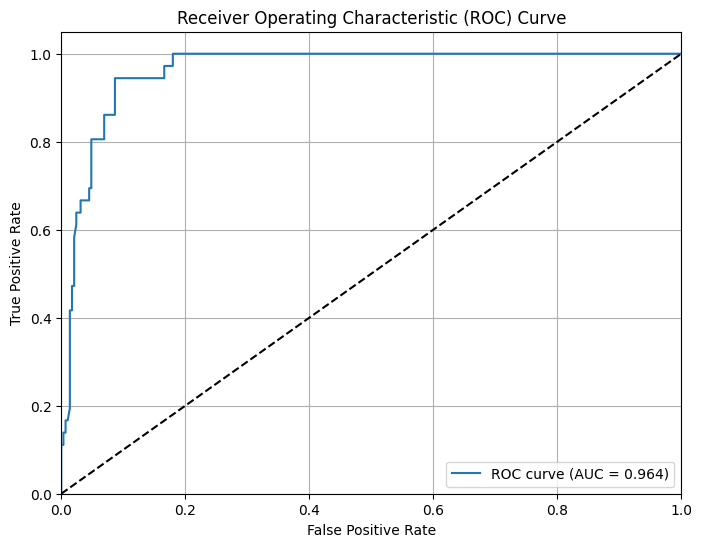

In [18]:
# Plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test_encoded, y_pred_proba_xgb):.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Create predictor + predict n days based on recall

In [20]:
# Restrict cpus to 1
import os
os.environ["OMP_NUM_THREADS"] = "1"

class MyPredictor():
    def __init__(self):
        self.extractor = PDFFeatureExtractor(num_chunks=1, num_pages_to_sample=8)


        
    def run(self, media_bytes):
        features_raw = self.extractor.run(media_bytes)[0][0]
        features = flatten_per_page_features(features_raw, sample_to_k_page_features=8)
        return xgb_classifier.predict_proba(pd.DataFrame([features]))
    


predictor = MyPredictor()
from tqdm import tqdm


all_test_documents = test_documents["truncated"] + test_documents["non_truncated"]
xgb_predictions = {
    "truncated": [],
    "non_truncated": [],
}


for truncation in ["truncated", "non_truncated"]:
    for doc in tqdm(test_documents[truncation]):
        ocr_prob = predictor.run(doc["bytes"])[0][1]
        xgb_predictions[truncation].append(ocr_prob)



 65%|██████▌   | 182/278 [00:12<00:07, 13.56it/s]

MuPDF error: syntax error: Failed to read JPX header

MuPDF error: syntax error: Failed to read JPX header

MuPDF error: syntax error: Failed to read JPX header



100%|██████████| 278/278 [00:19<00:00, 13.97it/s]


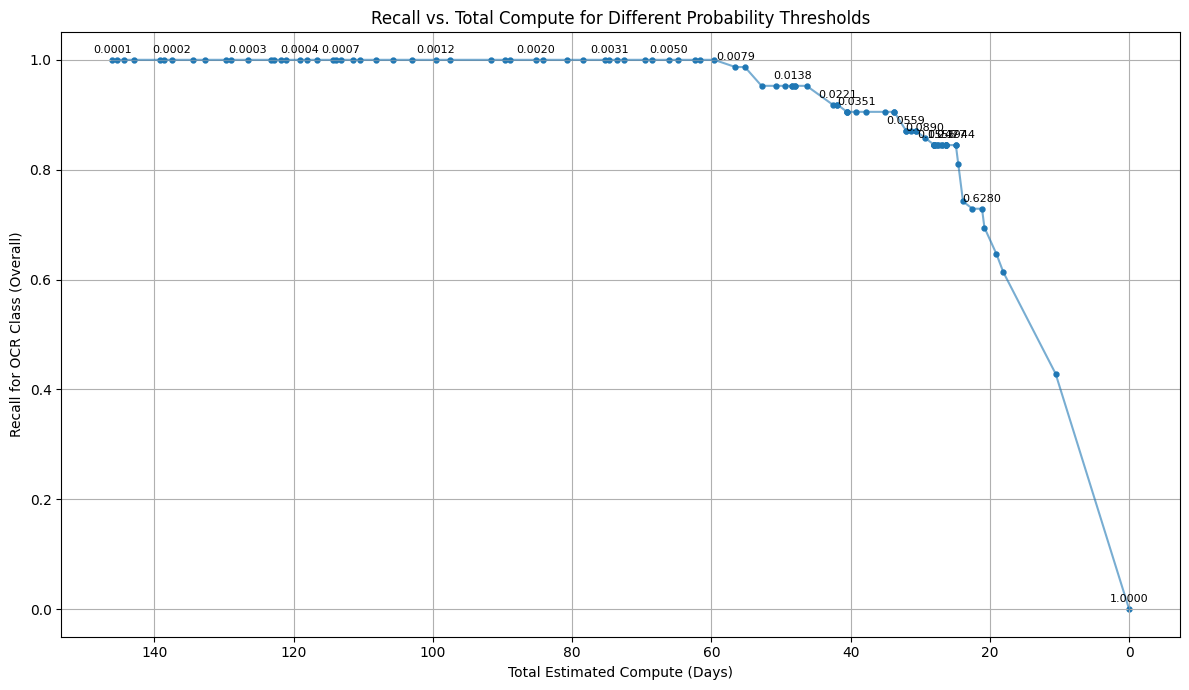

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# STATIC Variables based on pdfs corpora
DOCUMENTS_NON_TRUNCATED = 1215386294
PAGES_NON_TRUNCATED_AVG = 6.5

DOCUMENTS_TRUNCATED = 135790129
PAGES_TRUNCATED_AVG = 39
PAGES_SEC = 5


GPUS = 24*8

y_test_dict = {
    "truncated": pd.DataFrame(test_documents_with_features["truncated"])["class"].map({"NOCR": 0, "OCR": 1}),
    "non_truncated": pd.DataFrame(test_documents_with_features["non_truncated"])["class"].map({"NOCR": 0, "OCR": 1}),
}

# --- Prepare combined true labels and predicted probabilities ---
y_true_truncated = y_test_dict["truncated"].values
y_true_non_truncated = y_test_dict["non_truncated"].values

# Ensure these are numpy arrays for consistent operations
probs_truncated = np.array(xgb_predictions["truncated"])
probs_non_truncated = np.array(xgb_predictions["non_truncated"])

# --- Define probability thresholds ---
# From 1 down to 0.0001
thresholds = np.logspace(0, -4, num=100) # 100 points from 10^0 to 10^-4

recalls = []
compute_days_list = []

# --- Iterate over thresholds ---
for threshold in thresholds:
    # 1. Calculate prediction rates for this threshold
    # Proportion of truncated documents predicted as OCR
    binary_preds_truncated = (probs_truncated > threshold).astype(int)
    if len(binary_preds_truncated) > 0:
        current_prediction_rate_truncated = np.mean(binary_preds_truncated)
    else:
        current_prediction_rate_truncated = 0

    # 2. Proportion of non-truncated documents predicted as OCR
    binary_preds_non_truncated = (probs_non_truncated > threshold).astype(int)
    if len(binary_preds_non_truncated) > 0:
        current_prediction_rate_non_truncated = np.mean(binary_preds_non_truncated)
    else:
        current_prediction_rate_non_truncated = 0

    # 3. Calculate overall recall for OCR class (class 1)

    recall_truncated = recall_score(y_true_truncated, binary_preds_truncated, pos_label=1, zero_division=0)
    recall_non_truncated = recall_score(y_true_non_truncated, binary_preds_non_truncated, pos_label=1, zero_division=0)
    current_recall = (recall_truncated * len(y_true_truncated) + recall_non_truncated * len(y_true_non_truncated)) / (len(y_true_truncated) + len(y_true_non_truncated))
    recalls.append(current_recall)

        
    # 4. Calculate total compute for this threshold
    total_compute_pages = (
        DOCUMENTS_NON_TRUNCATED * PAGES_NON_TRUNCATED_AVG * current_prediction_rate_non_truncated +
        DOCUMENTS_TRUNCATED * PAGES_TRUNCATED_AVG * current_prediction_rate_truncated
    )
    
    total_days_for_threshold = total_compute_pages / PAGES_SEC / 60 / 60 / 24 / GPUS
    compute_days_list.append(total_days_for_threshold)

# --- Create the plot ---
# --- Create the plot ---
plt.figure(figsize=(12, 7))

# Create scatter plot with thresholds as annotations
scatter = plt.scatter(compute_days_list, recalls, marker='.', s=50)

# Connect points with a line
plt.plot(compute_days_list, recalls, linestyle='-', alpha=0.6)

# Add threshold annotations to selected points
# To avoid overcrowding, annotate only a subset of points (20 points)
indices = np.linspace(0, len(thresholds) - 1, 20, dtype=int)
for i in indices:
    threshold = thresholds[i]
    plt.annotate(f'{threshold:.4f}', 
                 (compute_days_list[i], recalls[i]),
                 textcoords="offset points", 
                 xytext=(0, 5), 
                 ha='center',
                 fontsize=8)

plt.xlabel("Total Estimated Compute (Days)")
plt.ylabel("Recall for OCR Class (Overall)")
plt.title("Recall vs. Total Compute for Different Probability Thresholds")
plt.grid(True)
plt.gca().invert_xaxis() # Often, lower compute (higher threshold) is on the left
plt.tight_layout()
plt.show()